In [106]:
from netCDF4 import Dataset
from netCDFfunc.utility import get_data_sequence, get_data_A, get_data_by_date, save_img, show_img, masking, cropping

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from collections import Counter
import datetime as dt

import math
from tqdm.notebook import tqdm

In [2]:
base_dir = '/Volumes/T7/AVHRR_OI_SST/v2.1/'

In [71]:
def save_img(arr, output_path, time, lon=None, lat=None, figsize=(), show_img=False, is_grade=False):
    if figsize == ():
        x, y = arr.shape
    else :
        x,y = figsize
        
    x = x/60
    y = y/60
    
    fig, ax = plt.subplots(figsize=(24,12))
    gca_ax = plt.gca()
    
    if arr.dtype == np.float32:
        np.place(arr, arr[:,:]==-999, np.nan)
        
    if is_grade == False :
        cmap = cm.jet.copy()
        vmax = 15
        vmin = 0
        
    elif is_grade == True :
        vmax = 5
        vmin = 0
        
        ice = np.array([240/256, 240/256, 240/256, 1])
        grade_0 = np.array([179/256, 241/256, 255/256, 1])
        grade_1 = np.array([255/256, 255/256, 128/256, 1])
        grade_2 = np.array([255/256, 179/256, 53/256, 1])
        grade_3 = np.array([255/256, 129/256, 0/256, 1])
        grade_4 = np.array([203/256, 76/256, 1/256, 1])
        grade_5 = np.array([153/256, 26/256, 0/256, 1])
        new_cmap = np.array([grade_0, grade_1, grade_2, grade_3, grade_4, grade_5])
#         if -1 not in arr :
#             cmap = cm.get_cmap('jet', 6)
#             new_cmap = cmap(np.linspace(0,1,6))
#             new_cmap = grades[1:]
            
#         elif -1 in arr :
#         cmap = cm.get_cmap('jet', 6)
#         new_cmap = cmap(np.linspace(0,1,6))
#         new_cmap = grades

        if 5 not in arr :
            new_cmap = new_cmap[:-1]
            if 4 not in arr :
                new_cmap = new_cmap[:-1]
                if 3 not in arr :
                    new_cmap = new_cmap[:-1]
                    if 2 not in arr :
                        new_cmap = new_cmap[:-1]
                        if 1 not in arr :
                            new_cmap = new_cmap[:-1]
#         if 5 not in arr :
#             new_cmap = new_cmap[new_cmap != grade_5]
#         if 4 not in arr :
#             new_cmap = new_cmap[new_cmap != grade_4]
#         if 3 not in arr :
#             new_cmap = new_cmap[new_cmap != grade_3]
#         if 2 not in arr :
#             new_cmap = new_cmap[new_cmap != grade_2]
#         if 1 not in arr :
#             new_cmap = new_cmap[new_cmap != grade_1]
            
        cmap = ListedColormap(new_cmap)
        
    cmap.set_bad(color='gray')
    cmap.set_under(color=np.array([230/256, 230/256, 230/256, 1]))
    
        
    if type(lat) != np.ndarray or type(lon) != np.ndarray :
        if is_grade == False : im = plt.imshow(arr, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
        elif is_grade == True : im = plt.imshow(arr, cmap=cmap, origin='lower', vmin=vmin)#, vmax=vmax)
    else :
        im = plt.imshow(arr, cmap=cmap, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], vmin=vmin, vmax=vmax) 
    
        plt.xticks(range(0,361, 20))
        plt.yticks(range(-80,81,20))
        plt.grid(True, linestyle='--', color='black')
        
        x_labels = ['20°E','40°E','60°E','80°E','100°E','120°E','140°E','160°E','180°','160°W','140°W','120°W','100°W','80°W','60°W','40°W','20°W','0','20°E']
        y_labels = ['80°S','60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N']
        ax.set_xticklabels(x_labels)
        ax.set_yticklabels(y_labels)
    
    divider = make_axes_locatable(gca_ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    plt.colorbar(im, cax=cax)
    plt.text(-30,0.9,f'{time}',{'fontsize':30}, transform=plt.gca().transAxes, va='top', ha='left')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')

    if show_img == True :
        plt.show()
    plt.close()

# ice mask

In [91]:
ice_mask = get_data_by_date(base_dir=base_dir,
                            get_data_func=get_data_A,
                            var_name='ice',
                            start_date=(1982,1,1),
                            end_date=(2020,12,31),
                            is_mask=True)

  0%|          | 0/39 [00:00<?, ?it/s]

In [13]:
land_ds = get_data_by_date(base_dir=base_dir,
                            get_data_func=get_data_A,
                            var_name='sst',
                            start_date=(1982,1,1),
                            end_date=(1982,1,2),
                            is_mask=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [92]:
land_mask = land_ds[(1,1)][0]
days = [31,28,31,30,31,30,31,31,30,31,30,31]
for month, day_len in zip(range(1,13), days):
    for day in range(1,day_len+1):
        sum_ice = np.sum(np.invert(ice_mask[(month,day)]), axis=0)
        masked_ice = masking(sum_ice, land_mask, fill_value=-5)
        masked_ice = masked_ice.astype(np.float32)
        np.place(masked_ice, masked_ice[:,:] == 0, np.nan)
        date = dt.date(2021, month,day).strftime('%m%d')
        save_img(cropping(masked_ice, 'global'), f'/Volumes/T7/intermediate_output/global_ice_dist/{date}', date)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb20a47be50> (for post_execute):


KeyboardInterrupt: 

# heatlevel 

In [5]:
ds_in = get_data_by_date(base_dir=base_dir,
                            get_data_func=get_data_A,
                            var_name='sst',
                            start_date=(1981,9,1),
                            end_date=(2011,8,31))

  0%|          | 0/31 [00:00<?, ?it/s]

In [6]:
ds_ice = get_data_by_date(base_dir=base_dir,
                            get_data_func=get_data_A,
                            var_name='ice',
                            start_date=(1981,9,1),
                            end_date=(2011,8,31),
                          is_mask=True)

  0%|          | 0/31 [00:00<?, ?it/s]

In [7]:
ds_sst = get_data_by_date(base_dir=base_dir,
                            get_data_func=get_data_A,
                            var_name='sst',
                            start_date=(2020,1,1),
                            end_date=(2020,12,31))

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
ds_sst_ice = get_data_by_date(base_dir=base_dir,
                            get_data_func=get_data_A,
                            var_name='ice',
                            start_date=(2020,1,1),
                            end_date=(2020,12,31),
                            is_mask=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
days = [31,28,31,30,31,30,31,31,30,31,30,31]
for month, day_len in tqdm(zip(range(1,13), days)):
    for day in range(1,day_len+1):
        for y in range(30):
            ds_in[(month,day)][y] = masking(ds_in[(month,day)][y], np.invert(ds_ice[(month,day)][y]), fill_value=np.nan)

0it [00:00, ?it/s]

In [171]:
days = [31,28,31,30,31,30,31,31,30,31,30,31]
chk = []
for month, day_len in tqdm(zip(range(1,13), days)):
    for day in range(1,day_len+1):
        pctl = np.percentile(ds_in[(month, day)], 90, axis=0)
        np.place(pctl, pctl[:,:]==-999, np.nan)
        sst = ds_sst[(month, day)][0]
        max_anomally = np.nanmax(sst - pctl)
        chk.append(max_anomally)

0it [00:00, ?it/s]

In [73]:
pctl = np.nanpercentile(ds_in[(5, 20)], 90, axis=0)
pctl = cropping(pctl, 'rok')
np.place(pctl, pctl[:,:]==-999, np.nan)

std = np.nanstd(ds_in[(5, 20)], axis=0)
std = cropping(std, 'rok')

sst = ds_sst[(5, 20)][0]
sst = cropping(sst, 'rok')

ice = ds_sst_ice[(5, 20)][0]
ice = cropping(ice, 'rok')

anormally = sst - pctl
np.place(anormally, anormally[:,:]<0, 0)
anormally = masking(anormally, np.invert(ice), fill_value=-1)

heat_level = np.ceil(anormally / std)
heat_level = masking(heat_level, np.invert(ice), fill_value=-1)

/var/folders/3k/05vd5sp53wbgspztyxv0ksfm0000gn/T/ipykernel_66748/2582498119.py:18: RuntimeWarning: divide by zero encountered in true_divide
  heat_level = np.ceil(anormally / std)


In [74]:
np.unique(heat_level)

array([-1.,  0.,  1.,  2.,  3., 14., nan])

In [72]:
days = [31,28,31,30,31,30,31,31,30,31,30,31] #
for month, day_len in tqdm(zip(range(1,13), days)):
    for day in range(1,day_len+1):
        pctl = np.nanpercentile(ds_in[(month, day)], 90, axis=0)
        pctl = cropping(pctl, 'rok')
        np.place(pctl, pctl[:,:]==-999, np.nan)
        
        std = np.nanstd(ds_in[(month, day)], axis=0)
        std = cropping(std, 'rok')
        
        sst = ds_sst[(month, day)][0]
        sst = cropping(sst, 'rok')
        
        ice = ds_sst_ice[(month, day)][0]
        ice = cropping(ice, 'rok')
        
        anormally = sst - pctl
        np.place(anormally, anormally[:,:]<0, 0)
        anormally = masking(anormally, np.invert(ice), fill_value=-1)
        
        heat_level = np.ceil(anormally / std)
        heat_level = masking(heat_level, np.invert(ice), fill_value=-1)
        np.place(heat_level, heat_level[:,:]>5, 5)
        
        date = dt.date(1000, month,day).strftime('%m%d')
        
        save_img(anormally, f'/Volumes/T7/intermediate_output/rok_anormally_heatlevel/{date}_anomally', date)
        save_img(heat_level, f'/Volumes/T7/intermediate_output/rok_anormally_heatlevel/{date}_heat_level', date, is_grade=True)

0it [00:00, ?it/s]

/var/folders/3k/05vd5sp53wbgspztyxv0ksfm0000gn/T/ipykernel_66748/1799803341.py:21: RuntimeWarning: divide by zero encountered in true_divide
  heat_level = np.ceil(anormally / std)
/var/folders/3k/05vd5sp53wbgspztyxv0ksfm0000gn/T/ipykernel_66748/1799803341.py:21: RuntimeWarning: invalid value encountered in true_divide
  heat_level = np.ceil(anormally / std)


KeyboardInterrupt: 

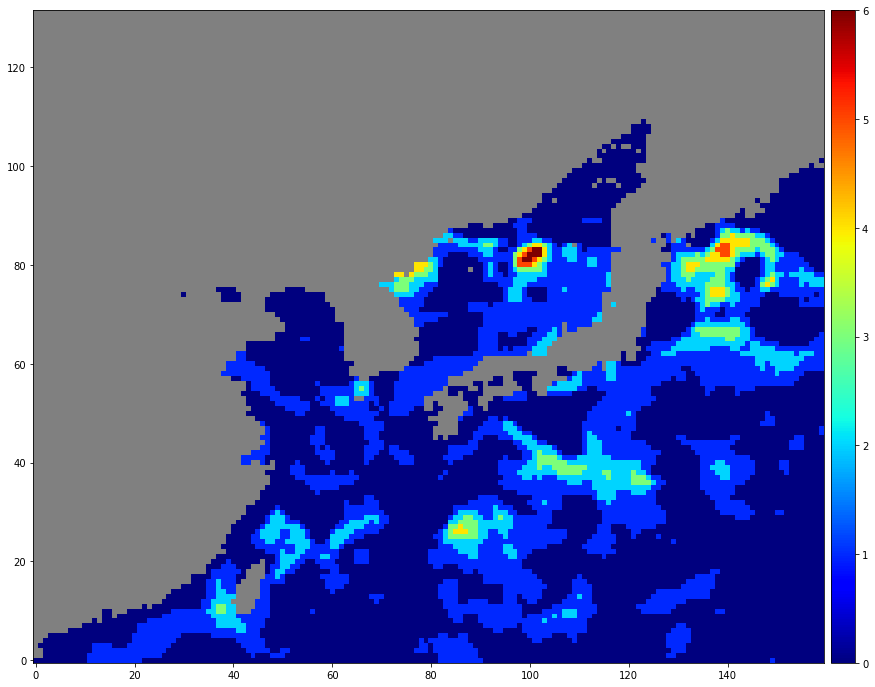

In [135]:
show_img(cropping(heat_level, 'rok'))

In [ ]:
land_mask = land_ds[(1,1)][0]
days = [31,28,31,30,31,30,31,31,30,31,30,31]
for month, day_len in zip(range(1,13), days):
    for day in range(1,day_len+1):
        sum_ice = np.sum(np.invert(ice_mask[(month,day)]), axis=0)
        masked_ice = masking(sum_ice, land_mask, fill_value=-5)
        masked_ice = masked_ice.astype(np.float32)
        np.place(masked_ice, masked_ice[:,:] == 0, np.nan)
        date = dt.date(2021, month,day).strftime('%m%d')
        save_img(cropping(masked_ice, 'rok'), f'/Volumes/T7/intermediate_output/global_ice_dist/{date}', date)